# torch 사용 흐름  
1. data preprocessing
2. data load (pipe line)  ? 제너레이터와 같은 방식인가
3. define model  
4. loss, optimizer define  
5. train, test  
for i in epoch:
    for j in batch:
        optimizer.zero_grad()
        out = model(in)
        loss = loss_func(out,label)
        loss.backward()
        optimizer.step()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# 1.MNIST train, test dataset 가져오기

In [ ]:
#train=True mean?
mnist_train = dset.MNIST("",train=True,transform=transforms.ToTensor(),
                        target_transform=None, download=True)
mnist_test = dset.MNIST("",train=False,transform=transforms.ToTensor(),
                        target_transform=None, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 2.대략적인 데이터 형태

mnist_train len: 60000
mnist_test len: 10000
Image data shape:  torch.Size([1, 28, 28])
label:  5


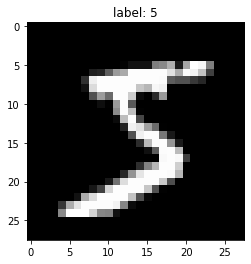

In [ ]:
print("mnist_train len:", len(mnist_train))
print("mnist_test len:", len(mnist_test))

Image, label = mnist_train.__getitem__(0)
print("Image data shape: ", Image.size())
print("label: ",label)

img = Image.numpy()
plt.title("label: %d"%label)
plt.imshow(img[0], cmap = 'gray')
plt.show()

# 3. 데이터 로드함수  
학습시킬 때 batch_dize 단위로 끊어서 로드하기 위함

In [ ]:
batch_size = 1024
learning_rate = 0.01
num_epoch = 400

In [ ]:
train_loader = torch.utils.data.DataLoader(mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=2,# num_workers는 cpu 코어 개수
                                          drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          drop_last=True)

데이터 로드함수 이해하기

[0]
한 번에 로드되는 데이터 크기:  1024


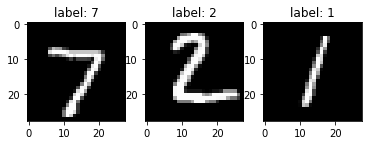

[1]
한 번에 로드되는 데이터 크기:  1024


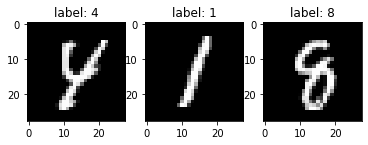

[2]
한 번에 로드되는 데이터 크기:  1024


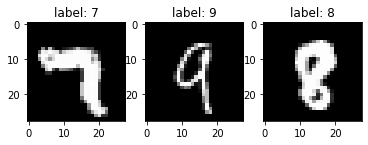

[3]
한 번에 로드되는 데이터 크기:  1024


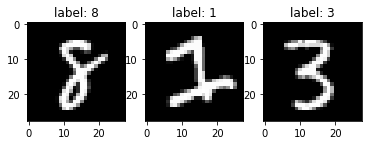

[4]
한 번에 로드되는 데이터 크기:  1024


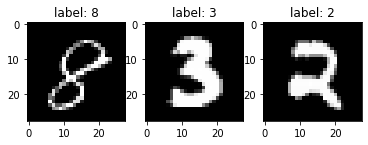

[5]
한 번에 로드되는 데이터 크기:  1024


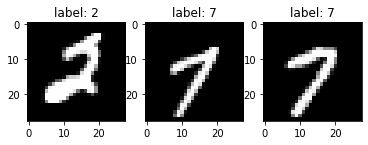

In [ ]:
n = 3
for i ,[imgs, labels] in enumerate(test_loader):
    if i>5:
        break
    
    print("[%d]"%i)
    print("한 번에 로드되는 데이터 크기: ", len(imgs))
    
    for j in range(n):
        img = imgs[j].numpy()
        img = img.reshape((img.shape[1], img.shape[2]))
        
        plt.subplot(1, n, j+1)
        plt.imshow(img, cmap='gray')
        plt.title("label: %d"%labels[j])
    plt.show()

# 4.모델 선언

In [ ]:
model = nn.Sequential(
    nn.Linear(28*28,256),
    nn.Sigmoid(),
    nn.Linear(256,128),
    nn.Linear(128,10),
)

In [ ]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader):
        img = imgs
        label = Variable(labels)
        
        img = img.reshape((img.shape[0],img.shape[2], img.shape[3]))
        
        img = img.reshape((img.shape[0],img.shape[1]*img.shape[2]))
        img = Variable(img, requires_grad=False)
        output = imodel(img)
        
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 9.765625


# 5.loss, optimizer

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 6.학습

In [ ]:
%time
num_epoch = 400
for j in range(num_epoch):
    for i ,[imgs, labels] in enumerate(train_loader):
        img = imgs
        label = Variable(labels)
        
        img = img.reshape((img.shape[0],img.shape[2], img.shape[3]))
        
        img = img.reshape((img.shape[0],img.shape[1]*img.shape[2]))
        img = Variable(img, requires_grad=True)
        
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output, label)
        
        loss.backward()
        optimizer.step()
        
    if j%50 == 0:
        print("%d.."%j)
        ComputeAccr(test_loader, model)
        print(loss)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
0..
Accuracy of Test Data: 11.295573234558105
tensor(2.2978, grad_fn=<NllLossBackward>)
50..
Accuracy of Test Data: 80.67491149902344
tensor(0.7203, grad_fn=<NllLossBackward>)
100..
Accuracy of Test Data: 88.37890625
tensor(0.4582, grad_fn=<NllLossBackward>)
150..
Accuracy of Test Data: 89.96310424804688
tensor(0.3168, grad_fn=<NllLossBackward>)
200..
Accuracy of Test Data: 90.69010162353516
tensor(0.3112, grad_fn=<NllLossBackward>)
250..
Accuracy of Test Data: 91.17838287353516
tensor(0.3241, grad_fn=<NllLossBackward>)
300..
Accuracy of Test Data: 91.61241149902344
tensor(0.3024, grad_fn=<NllLossBackward>)
350..
Accuracy of Test Data: 91.82942962646484
tensor(0.3025, grad_fn=<NllLossBackward>)


# 7.테스트

In [ ]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 91.90538024902344


# 8.학습된 파라미터 저장

In [ ]:
# netname=''
# torch.save(model, netname,)
# #model = torch.load(netname)

# 9.(Optional) 실습1에 쓰인 .npz만드려면?

In [ ]:
# np.savez_compressed('',
#                    W1=W1, b1=b1,
#                    W2=W2, b2=b2,
#                    W3=W3, b3=b3,
#                    )